# Shaku
**A demonstration of the goal distance and measurement framework in Kyudo**

In [168]:
# Imports for package management
import os
import json

from collections import Counter
from nltk import wordpunct_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn import decomposition
from sklearn.metrics.pairwise import euclidean_distances

from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models import HoverTool


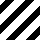
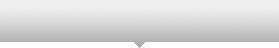
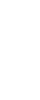
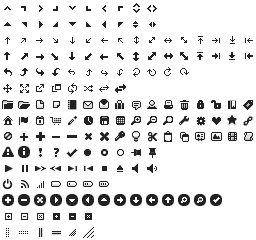
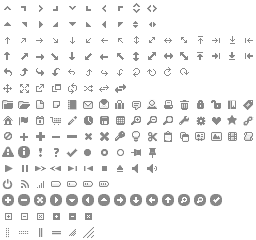
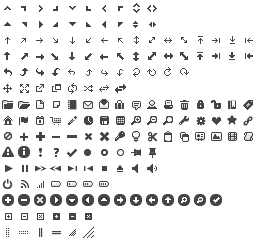
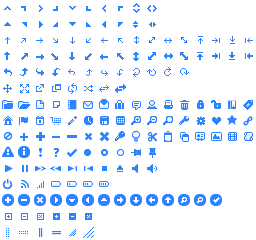
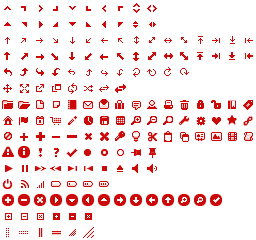
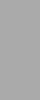
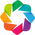
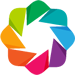
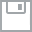
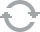
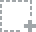
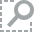
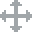
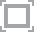
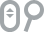

In [155]:
# Load Bokeh for visualization
output_notebook()

In [26]:
# Module constants and fixtures
FIXTURES    = os.path.join(os.getcwd(), 'fixtures')
CORPUS_PATH = os.path.join(FIXTURES, 'questions.corpus.json')

# Tasks Constants
WHO    = 'who'
WHAT   = 'WHAT'
WHEN   = 'WHEN'
WHERE  = 'WHERE'
WHY    = 'WHY'
HOW    = 'HOW'
EXIST  = 'EXISTENTIAL'
PERMIT = 'PERMISSION'
UNKNWN = 'UNKNOWN'

# Task Mapping
TASK_MAP    = {
    'who':    WHO, 
    'what':   WHAT,
    'when':   WHEN,
    'where':  WHERE,
    'why':    WHY,
    'how':    HOW,
    'which':  WHAT,
    'in':     WHAT,
    'are':    EXIST,
    'on':     WHAT,
    'can':    PERMIT,
    'does':   EXIST,
    'is':     EXIST,
    'at':     WHERE,
    'for':    WHAT,
    'with':   WHAT,
    'did':    EXIST,
    'whats':  WHAT,
    'should': PERMIT
}

In [70]:
def read_data(corpus=CORPUS_PATH):
    """
    Reads and parses corpus data and yields each item at a time.
    """
    with open(corpus, 'r') as f:
        data = json.load(f)
        for item in data:
            yield item

## Representation and Modeling 

In this section a pipeline is created to extract the representation of natural language questions from raw text. The model we are using is one of concepts, tasks, and context. The concepts are simply represented as TF-IDF vector scores. A rule based system currently extracts the tasks; and the context needs to be embedded in the dataset and has not yet been included.

In [114]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    Preprocesses text to ensure that it is lower cased.
    """

    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        return [
            text.strip().lower()
            for text in texts
        ]


class TaskVectorizer(BaseEstimator, TransformerMixin):
    """
    Provide the task feature from an utterance.
    """
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, utterances):
        return [
            self.extract_task(utterance) 
            for utterance in utterances
        ]
    
    def extract_task(self, utterance):
        tokens = wordpunct_tokenize(utterance)
        first  = tokens[0]
        if first in TASK_MAP:
            return {'task': TASK_MAP[first]}
        
        return {'task': UNKNWN}

## Construct the Feature Pipeline
feats = Pipeline([
    # Preprocess text to make sure it is normalized.
    ('preprocess', TextPreprocessor()),
        
    # Use FeatureUnion to combine concept, task, and context features 
    ('union', FeatureUnion(
        
        # Create union of TF-IDF and Task Vectorizers
        transformer_list=[
            
            # Pipeline for Concept Extraction
            ('concepts', Pipeline([
                ('tfidf', TfidfVectorizer(tokenizer=wordpunct_tokenize)),
                ('best', TruncatedSVD(n_components=50)),
            ])),
                    
            # Pipeline for Task Extraction
            ('tasks', Pipeline([
                ('tasks', TaskVectorizer()),
                ('vect', DictVectorizer()),
            ])),
            
                    
        ],

        # weight components in FeatureUnion
        transformer_weights={
            'concepts': 0.45,
            'tasks': 0.55,
        },
    )),
])

In [115]:
# Fit the feature pipeline from the corpus
feats.fit(read_data())

Pipeline(steps=[('preprocess', TextPreprocessor()), ('union', FeatureUnion(n_jobs=1,
       transformer_list=[('concepts', Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowerca...ort=True,
        sparse=True))]))],
       transformer_weights={'tasks': 0.55, 'concepts': 0.45}))])

In [156]:
# Print the feature representation of a question
def show_feature_representation(question):
    print feats.transform((question,))

# Alias for quickly showing the representation
sfr = show_feature_representation

In [157]:
sfr('where is the food truck?')

  (0, 0)	0.0852185900591
  (0, 1)	0.0315209305621
  (0, 2)	0.0568005945134
  (0, 3)	-0.0361151851708
  (0, 4)	-0.0675097464539
  (0, 5)	0.0134277368047
  (0, 6)	0.0321247400552
  (0, 7)	-0.025076720612
  (0, 8)	0.000970146379553
  (0, 9)	0.00561650562651
  (0, 10)	-0.00737313035143
  (0, 11)	-0.0165310957207
  (0, 12)	-0.00171918818435
  (0, 13)	0.000879865594896
  (0, 14)	0.0198901209588
  (0, 15)	-0.00839899388027
  (0, 16)	0.00207597687238
  (0, 17)	0.00398163196399
  (0, 18)	0.00573309568078
  (0, 19)	-0.0138881550846
  (0, 20)	-0.00294278308996
  (0, 21)	0.00599228288051
  (0, 22)	0.00292876177885
  (0, 23)	-0.000103456373711
  (0, 24)	-0.0090374308287
  :	:
  (0, 26)	0.0126999308888
  (0, 27)	0.00487227836282
  (0, 28)	-0.00910529413833
  (0, 29)	-0.00417515325024
  (0, 30)	-0.00391499754855
  (0, 31)	-0.0104588009118
  (0, 32)	0.00295583479896
  (0, 33)	-0.00299686135014
  (0, 34)	0.0111574907193
  (0, 35)	-0.0027653737603
  (0, 36)	0.00541407450091
  (0, 37)	-0.00439607256941
 

### Visualization of Goal Space

In this section we utilize a PCA (principle component analysis) to decompose the multi-dimensional goal space into a two dimensional representation. This will allow us to visualize clusters and do a lightweight analysis of "closeness".

In [158]:
# Visualization of Goal Space using PCA Decomposition

features = feats.transform(read_data()).toarray()
pca = decomposition.PCA(n_components=2)
X   = pca.fit_transform(features)

source = ColumnDataSource(
        data=dict(
            x=X[:, 0],
            y=X[:, 1],
            q=list(read_data()),
        )
    )

hover = HoverTool(
        tooltips=[
            ("Q:", "@q"),
        ]
    )

plt = figure(title="PCA Decomposition of Goal Space", width=960, height=540, tools="pan,box_zoom,reset,resize,save")
plt.add_tools(hover)
plt.scatter('x', 'y', source=source, marker='circle_x', line_color="#6666ee", fill_color="#6666ff", fill_alpha=0.5, size=9)

show(plt)

## Nearest Neighbors

The model we've selected for goal advice is K Nearest Neighbors, where k=5. This model will allow us to quickly find related questions for guidance in an interactive system. However, instance based approaches do have their problems, so this is initial findings only.

In [159]:
# Build kNearestNeighbors clustering mechanism
nbrs = NearestNeighbors(n_neighbors=5).fit(feats.transform(read_data()))

In [190]:
def find_related_questions(question):
    features = feats.transform((question,))
    distances, indices = nbrs.kneighbors(features)
    for idx, text in enumerate(read_data()):
        if idx in indices:
            yield text

# Alias for easy interaction
frq = lambda q: "\n".join(find_related_questions(q))

In [192]:
print frq('What are bizarre sports that people play in Washington DC?')

what are bizarre events that happen in washington dc?
what are bizarre things that people eat in washington dc?
what are bizarre sports that people play in washington dc?
what religion are most people in pakistan?
what are portuguese people considered?


In [193]:
print frq('When are the Smithsonian museums open?')

when are the smithsonian museums open?
when are the summer and winter olympics held?
when were the texas rangers started?
when are the summer olympics held?
when were the phillies founded?


## Goal Trajectories

In this section, we will attempt to show guidance via the kNN model and how it can be used to improve goal trajectories.

In [188]:
def goal_distance(g1, g2):
    """
    Computes the distance between two knowledge goals.
    """
    X = feats.transform([g1, g2])
    d = euclidean_distances(X)
    
    return d[0,1]
    

def compute_trajectory_length(trajectory):
    """
    Computes the total distance of the trajectory by computing distances
    between questions using the feature tool and other helpers.
    """
    X = feats.transform(trajectory) # Transform the trajectory to vectors
    d = euclidean_distances(X)      # Compute all pairwise distances
    
    # Compute the sum of distances for all inner distances
    return sum(d[idx+1,idx] for idx in xrange(d.shape[1]-1))

In [198]:
# Create a test trajectory
trajectory = [
    "What are the most bizarre things to do in Washington DC that are also affordable?",
    "What are bizarre events that happen in Washington DC?",
    "What are bizarre things that people eat in Washington DC?",
    "Where can I find the best mambo sauce?",
    "What is food cart roulette?",
]

# Compute total length vs endpoint distance
tl = compute_trajectory_length(trajectory)
ep = goal_distance(trajectory[0], trajectory[-1])

print "Total Length:    {:0.6f}\nEndpoint Length: {:0.6f}".format(tl, ep)

# Show "guidance"
print "\nGuidance Sequence:\n"
for idx, goal in enumerate(trajectory):
    print "{}) {}".format(idx+1,goal)
    guidance = find_related_questions(goal)
    for guide in guidance:
        print "    + {}".format(guide)
    
    print "\n"

Total Length:    1.820013
Endpoint Length: 0.208667

Guidance Sequence:

1) What are the most bizarre things to do in Washington DC that are also affordable?
    + what are the most bizarre things to do in washington dc that are also affordable?
    + what are fun things to do in sacramento ca?
    + what are fun things to do in seattle wa?
    + what are fun things to do in denver colorado?
    + what are fun things to do in philadelphia?


2) What are bizarre events that happen in Washington DC?
    + what starts are in ursa minor?
    + what characters are in super mario bros?
    + what ingredients are in italian cuisine?
    + what are sacred sites in sunni islam?
    + what are bizarre events that happen in washington dc?


3) What are bizarre things that people eat in Washington DC?
    + what are bizarre events that happen in washington dc?
    + what are bizarre things that people eat in washington dc?
    + what are bizarre sports that people play in washington dc?
    + what